## Classification & Clustering Models for Vision Zero


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, 
                             confusion_matrix)

In [48]:
df = pd.read_csv("/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/data/cleaned_motor_vehicle_collisions.csv")

In [49]:
df.head()

,borough,crash_date,crash_time,day_of_week,month,is_weekend,hour,hour_category,season,pedestrian_involved,cyclist_involved,vehicle_type_code_1,vehicle_type_code_2,contributing_factor_vehicle_1,contributing_factor_vehicle_2,high_risk,KSI
0,Brooklyn,2023-11-01,01:29:00,2,11,0,1,Late_Night,Fall,0,0,MOPED,SEDAN,UNSPECIFIED,UNSPECIFIED,0,0
1,Queens,2022-09-22,16:16:00,3,9,0,16,Evening_Rush,Fall,0,0,SEDAN,E-SCOOTER,PASSING OR LANE USAGE IMPROPER,UNSPECIFIED,0,0
2,Queens,2023-01-12,21:00:00,3,1,0,21,Night,Winter,0,0,STATION WAGON/SPORT UTILITY VEHICLE,UNKNOWN,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0
3,Brooklyn,2022-07-12,17:50:00,1,7,0,17,Evening_Rush,Summer,0,0,SEDAN,UNKNOWN,OVERSIZED VEHICLE,UNSPECIFIED,0,0
4,Brooklyn,2022-04-24,16:45:00,6,4,1,16,Evening_Rush,Spring,0,0,STATION WAGON/SPORT UTILITY VEHICLE,STATION WAGON/SPORT UTILITY VEHICLE,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,0,0


In [50]:
display(df.shape)
display(df['KSI'].value_counts(normalize=True))

(342418, 17)

KSI
0    0.909865
1    0.090135
Name: proportion, dtype: float64

In [51]:
df.columns

Index(['borough', 'crash_date', 'crash_time', 'day_of_week', 'month',
       'is_weekend', 'hour', 'hour_category', 'season', 'pedestrian_involved',
       'cyclist_involved', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'high_risk', 'KSI'],
      dtype='object')

In [52]:
df[['hour', 'day_of_week', 'month','hour_category', 'season', 'borough']]

,hour,day_of_week,month,hour_category,season,borough
0,1,2,11,Late_Night,Fall,Brooklyn
1,16,3,9,Evening_Rush,Fall,Queens
2,21,3,1,Night,Winter,Queens
3,17,1,7,Evening_Rush,Summer,Brooklyn
4,16,6,4,Evening_Rush,Spring,Brooklyn
...,...,...,...,...,...,...
342413,20,1,12,Night,Winter,Brooklyn
342414,5,1,12,Late_Night,Winter,Manhattan
342415,10,3,11,Midday,Fall,Manhattan
342416,10,0,12,Midday,Winter,Manhattan


In [53]:
df[['is_weekend','pedestrian_involved', 'cyclist_involved', 'high_risk']]

,is_weekend,pedestrian_involved,cyclist_involved,high_risk
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,1,0,0,0
...,...,...,...,...
342413,0,1,0,0
342414,0,0,0,0
342415,0,0,0,0
342416,0,0,0,0


In [54]:
# let's define features for modeling
numerical_features = ['hour', 'day_of_week', 'month'] #numerical
categorical_features = ['borough', 'hour_category', 'season','is_weekend','pedestrian_involved', 'cyclist_involved', 'high_risk'] #categorical and binary

In [55]:
all_features = numerical_features + categorical_features

In [56]:
# Now, let't define the target variable Y, along with features X
X = df[all_features].copy()
y = df['KSI'].copy() # target variable, binary classification

### TRAIN-TEST SPLIT (STRATIFIED)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # stratify to maintain class balance

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Train KSI rate: {y_train.mean()*100:.2f}%")
print(f"Test KSI rate: {y_test.mean()*100:.2f}%") 


Training set: 273,934 samples
Test set: 68,484 samples
Train KSI rate: 9.01%
Test KSI rate: 9.01%


- the data is stratified to maintain the same proportion of KSI incidents in both training and test sets, to ensure that the model is trained and evaluated on representative samples of both classes. But we should not use accuracy as a metric because of the imbalanced data. We hould use precision and recall to confirm that the model is not ramdomly guessing.


In [58]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features)
    ]) #



- The pipeline standardizes numerical features using StandardScaler, which centers the data around a mean of 0 and scales it to have a standard deviation of 1(normal distrubution). This is important for the model performs better.

#### MODEL 1 - BASELINE (DUMMY CLASSIFIER)


In [59]:
# Let's create a baseline model using DummyClassifier

baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))
])

In [60]:
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

In [61]:
# Now let's evaluate the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline, zero_division=0)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_baseline)

print("Baseline Model Performance:")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"F1 Score: {baseline_f1:.4f}")
print(f"ROC-AUC: {baseline_roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_baseline)
print(conf_matrix)

Baseline Model Performance:
Accuracy: 0.9099
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC-AUC: 0.5000

Classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     62311
           1       0.00      0.00      0.00      6173

    accuracy                           0.91     68484
   macro avg       0.45      0.50      0.48     68484
weighted avg       0.83      0.91      0.87     68484

Confusion Matrix:
[[62311     0]
 [ 6173     0]]



--- Confusion Matrix for the baseline model ---


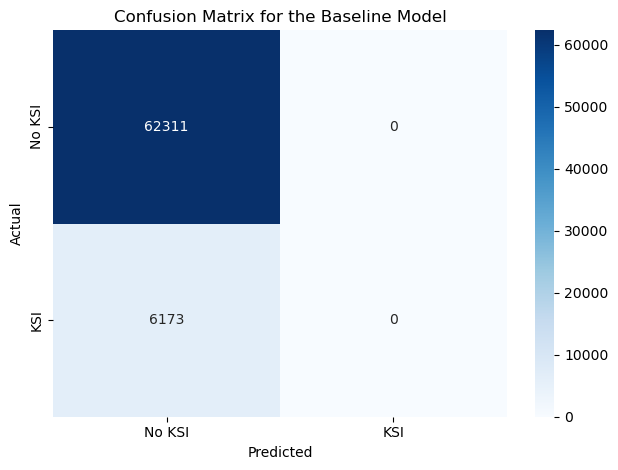

In [62]:
print("\n--- Confusion Matrix for the baseline model ---")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No KSI', 'KSI'], yticklabels=['No KSI', 'KSI'])
plt.title('Confusion Matrix for the Baseline Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
#plt.savefig('/Users/Marcy_Student/Desktop/Marcy_Projects/NYC-TrafficSafety-Modeling/figures/baseline_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Interpretation:
- The baseline model predicts most frequent class, which is 'no KSI' in this case. It has high accuracy 91% but zero recall for the positive class (KSI=1). This highlights the need for more sophisticated models to effectively identify KSI incidents.
- This shows us why is important to go beyond accuracy when evaluating models, especially with imbalanced datasets because the result can be misleading. 
